# Team 3 Aufgabe 2

## Use Case 6

## Erkennung von Fake News

### Beschreibung

In dem von uns behandelten Use Case geht es um die Erkennung von Fakenews mithilfe von Transformern. Dieser Use Case basiert auf dem Liar Datenset. Dieses wird im folgenden aufbereitet. Das Orginal enthält 10269 Zeilen. Für diesen Use Case werden die letzten 269 Zeilen gestrichen, da nur maximal 10000 Zeilen im Datensatz erlaubt sind. Weiters habe ich den Use Case auch mit 1000 und 5000 Zeilen versucht, wobei ich immer die ersten x Werte genommen habe. Das Datenset hat 6 verschiedene Labels von "Pants on Fire" über Wahr und Falsch. Für diesen Anwendungsfall ist es notwendig nur 1 und 0 als Labels zu haben. Für den Use Case habe ich entschieden die Kategorien in jeweils 3 Labels aufzuteilen. Das sind für Wahr: "True", "Mostly True" und "Half True". Wobei besonders letzterer ein Fall ist, der sowohl Wahr als auch als Falsch angesehen werden könnte. Um die Balance aufrecht zuerhalten, habe ich mich letztendlich dafür entschieden als wahr einzuordnen. Falsch sind die Kategorien: "Pants on Fire", "False" und "Barely True" zugeordnet.

#### Installs

In [57]:
!pip install datasets
!pip install transformers datasets torch
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
import spacy
nlp = spacy.load("en_core_web_sm")
from torch.utils.data import DataLoader, TensorDataset
import torch

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:



# Load the liar dataset
dataset = load_dataset("liar", trust_remote_code=True)



# Assuming dataset['train'] is already a DataFrame or a structure that can be converted to one
first_10000 = pd.DataFrame(dataset['train'][:10000])
first_1000 = pd.DataFrame(dataset['train'][:1000])
first_5000 = pd.DataFrame(dataset['train'][:5000])

# Display the DataFrame
print(first_10000)

df = first_10000

# Display a sample
#print(first_100)


              id  label                                          statement  \
0      2635.json      0  Says the Annies List political group supports ...   
1     10540.json      1  When did the decline of coal start? It started...   
2       324.json      2  Hillary Clinton agrees with John McCain "by vo...   
3      1123.json      0  Health care reform legislation is likely to ma...   
4      9028.json      1  The economic turnaround started at the end of ...   
...          ...    ...                                                ...   
9995   6196.json      4  Tim Kaine made Virginia the best state for bus...   
9996  13284.json      4  During his 18-year Senate career, (Russ Feingo...   
9997   2849.json      4  Says Gov. Rick Perrys administration has propo...   
9998   1031.json      1  "Walking in the door (Sonia Sotomayor) would b...   
9999   5475.json      0  [R]emember, the president proposed eliminating...   

                                                subject        

In [59]:
print(len(first_10000))

10000


In [60]:

# Display the top 25 records
print(df.head(25))

            id  label                                          statement  \
0    2635.json      0  Says the Annies List political group supports ...   
1   10540.json      1  When did the decline of coal start? It started...   
2     324.json      2  Hillary Clinton agrees with John McCain "by vo...   
3    1123.json      0  Health care reform legislation is likely to ma...   
4    9028.json      1  The economic turnaround started at the end of ...   
5   12465.json      3  The Chicago Bears have had more starting quart...   
6    2342.json      4  Jim Dunnam has not lived in the district he re...   
7     153.json      1  "I'm the only person on this stage who has wor...   
8    5602.json      1  However, it took $19.5 million in Oregon Lotte...   
9    9741.json      2  Says GOP primary opponents Glenn Grothman and ...   
10   7115.json      2  For the first time in history, the share of th...   
11   4148.json      1  Since 2000, nearly 12 million Americans have s...   
12   5947.js

In [61]:


# Define label mappings
label_mapping = {
    0: "Pants on Fire",
    1: "False",
    2: "Barely True",
    3: "Half True",
    4: "Mostly True",
    5: "True"
}

# Sample 15 instances per label (or all if <15 available)
sampled_df = df.groupby("label").apply(lambda x: x.sample(min(len(x), 15), random_state=42)).reset_index(drop=True)

# Replace label numbers with actual names
sampled_df["label"] = sampled_df["label"].map(label_mapping)

# Select only the relevant columns (statement and label)
final_df = sampled_df[["label", "statement"]]

# Save to CSV file
final_df.to_csv("liar_sampled_statements.csv", index=False)

# Save to Excel file
final_df.to_excel("liar_sampled_statements.xlsx", index=False)

# Display confirmation message
print("Files saved as 'liar_sampled_statements.csv' and 'liar_sampled_statements.xlsx'")



Files saved as 'liar_sampled_statements.csv' and 'liar_sampled_statements.xlsx'


<ipython-input-61-7e7c3570eb40>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("label").apply(lambda x: x.sample(min(len(x), 15), random_state=42)).reset_index(drop=True)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  object 
 1   label                 10000 non-null  object 
 2   statement             10000 non-null  object 
 3   subject               10000 non-null  object 
 4   speaker               10000 non-null  object 
 5   job_title             10000 non-null  object 
 6   state_info            10000 non-null  object 
 7   party_affiliation     10000 non-null  object 
 8   barely_true_counts    10000 non-null  float64
 9   false_counts          10000 non-null  float64
 10  half_true_counts      10000 non-null  float64
 11  mostly_true_counts    10000 non-null  float64
 12  pants_on_fire_counts  10000 non-null  float64
 13  context               10000 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
None

Firs

<ipython-input-62-302a53c3ddf1>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=df["label"].value_counts().index, palette="coolwarm")


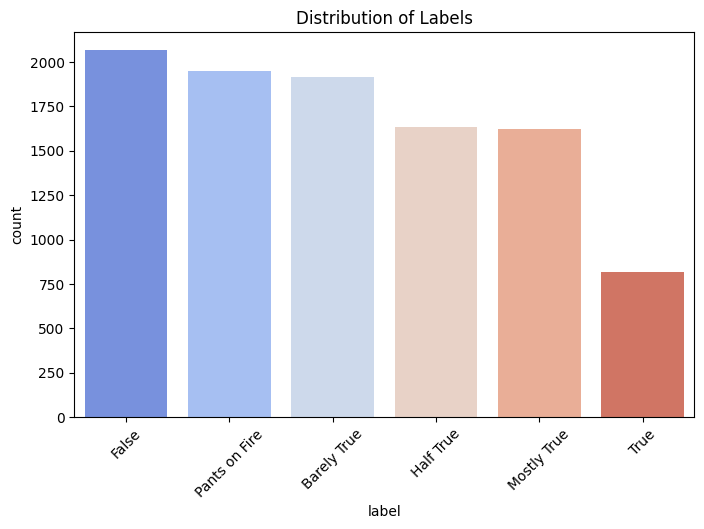

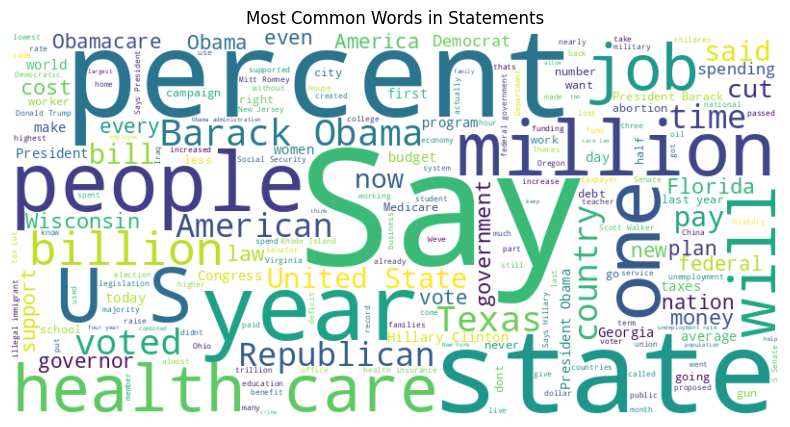

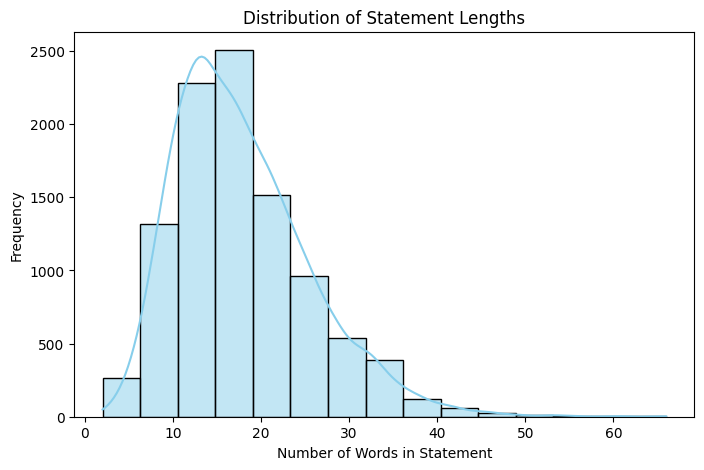

<ipython-input-62-302a53c3ddf1>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="statement_length", palette="viridis")


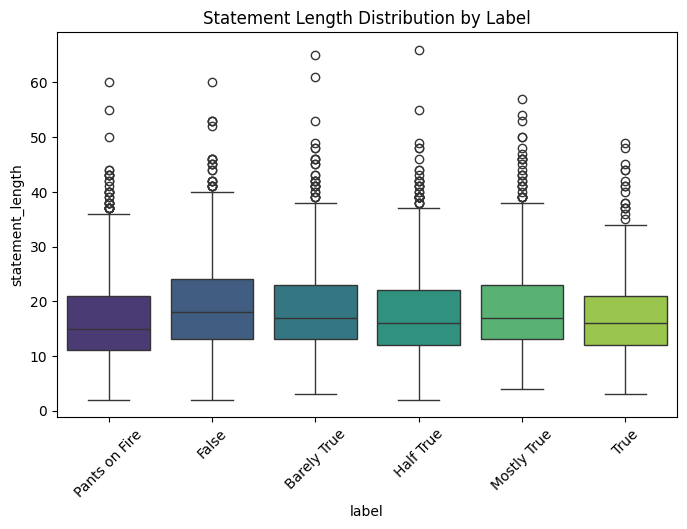

In [62]:

# Convert dataset to DataFrame
#df = first_100.to_pandas()

# Define label mappings
label_mapping = {
    0: "Pants on Fire",
    1: "False",
    2: "Barely True",
    3: "Half True",
    4: "Mostly True",
    5: "True"
}

# Replace label numbers with actual names
df["label"] = df["label"].map(label_mapping)

### 1. Display basic information about the dataset ###
print("Dataset Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())

### 2. Count of Labels ###
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index, palette="coolwarm")
plt.title("Distribution of Labels")
plt.xticks(rotation=45)
plt.show()

### 3. Word Cloud for Most Frequent Words in Statements ###
text = " ".join(df["statement"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Statements")
plt.show()

### 4. Statement Length Distribution ###
df["statement_length"] = df["statement"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df["statement_length"], bins=15, kde=True, color="skyblue")
plt.title("Distribution of Statement Lengths")
plt.xlabel("Number of Words in Statement")
plt.ylabel("Frequency")
plt.show()

### 5. Average Statement Length Per Label ###
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="label", y="statement_length", palette="viridis")
plt.title("Statement Length Distribution by Label")
plt.xticks(rotation=45)
plt.show()


In [63]:


stop_words = set(stopwords.words("english"))

def get_top_words(texts, n=10):
    words = " ".join(texts).lower().split()
    words = [word for word in words if word not in stop_words]
    return dict(Counter(words).most_common(n))

# Apply for each label
for label in df["label"].unique():
    top_words = get_top_words(df[df["label"] == label]["statement"], n=10)
    print(f"\nTop words for {label}:")
    print(top_words)



Top words for Pants on Fire:
{'says': 460, 'health': 127, 'obama': 127, 'state': 126, 'percent': 122, 'president': 121, 'tax': 106, 'would': 101, 'people': 99, 'new': 93}

Top words for False:
{'says': 478, 'percent': 218, 'state': 145, 'would': 128, 'obama': 127, 'tax': 120, 'health': 117, 'people': 114, 'million': 109, 'president': 105}

Top words for Barely True:
{'says': 386, 'percent': 242, 'state': 131, 'tax': 127, 'million': 120, 'people': 120, 'new': 93, 'would': 92, 'one': 90, 'states': 87}

Top words for Half True:
{'says': 317, 'percent': 195, 'state': 125, 'health': 86, 'tax': 81, 'since': 79, 'one': 76, 'states': 73, 'new': 71, 'every': 70}

Top words for Mostly True:
{'says': 442, 'percent': 122, 'obama': 112, 'tax': 99, 'state': 98, 'would': 94, 'health': 92, 'president': 88, 'people': 88, 'voted': 85}

Top words for True:
{'says': 221, 'obama': 89, 'president': 58, 'health': 56, 'barack': 52, 'care': 50, 'tax': 44, 'people': 43, 'u.s.': 42, 'new': 40}


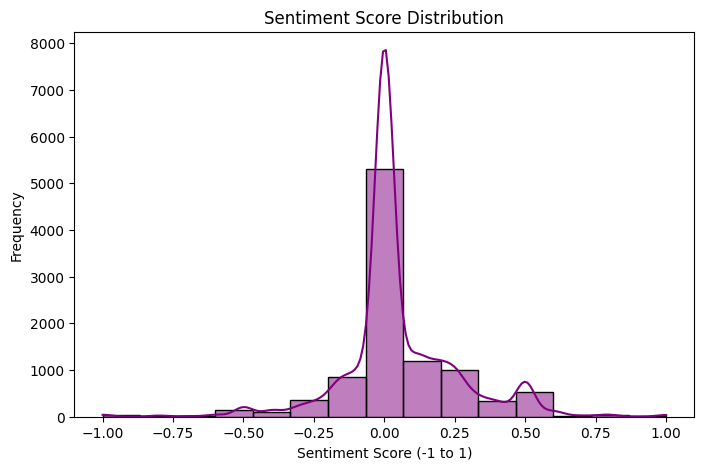

In [64]:


df["sentiment"] = df["statement"].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))
sns.histplot(df["sentiment"], bins=15, kde=True, color="purple")
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score (-1 to 1)")
plt.ylabel("Frequency")
plt.show()


In [65]:


def get_top_ngrams(texts, n=2, top_k=10):
    words = " ".join(texts).lower().split()
    n_grams = list(ngrams(words, n))
    return Counter(n_grams).most_common(top_k)

# Find bigrams & trigrams
top_bigrams = get_top_ngrams(df["statement"], n=2, top_k=10)
top_trigrams = get_top_ngrams(df["statement"], n=3, top_k=10)

print("Top Bigrams:", top_bigrams)
print("Top Trigrams:", top_trigrams)


Top Bigrams: [(('in', 'the'), 1322), (('of', 'the'), 998), (('percent', 'of'), 559), (('more', 'than'), 340), (('to', 'the'), 337), (('health', 'care'), 317), (('for', 'the'), 303), (('the', 'united'), 288), (('on', 'the'), 285), (('barack', 'obama'), 229)]
Top Trigrams: [(('the', 'united', 'states'), 196), (('percent', 'of', 'the'), 161), (('in', 'the', 'united'), 115), (('one', 'of', 'the'), 97), (('president', 'barack', 'obama'), 96), (('in', 'the', 'last'), 91), (('says', 'hillary', 'clinton'), 69), (('in', 'the', 'country.'), 62), (('the', 'federal', 'government'), 60), (('the', 'state', 'of'), 60)]


In [66]:


def extract_named_entities(texts):
    named_entities = []
    for text in texts:
        doc = nlp(text)
        named_entities.extend([ent.text for ent in doc.ents])
    return Counter(named_entities).most_common(25)

top_entities = extract_named_entities(df["statement"])
print("Top Named Entities:", top_entities)


Top Named Entities: [('Obama', 395), ('Texas', 334), ('U.S.', 281), ('Barack Obama', 269), ('Wisconsin', 216), ('Americans', 215), ('one', 208), ('Republican', 206), ('Florida', 204), ('the United States', 196), ('first', 193), ('American', 173), ('Medicare', 169), ('Congress', 167), ('Hillary Clinton', 163), ('America', 158), ('Democrats', 142), ('Republicans', 131), ('Social Security', 123), ('Georgia', 120), ('Senate', 114), ('Donald Trump', 109), ('today', 106), ('Obamacare', 102), ('Ohio', 100)]


In [67]:

# Define binary classification mapping
binary_label_mapping = {
    0: 0,  # Pants on Fire -> False (0)
    1: 0,  # False -> False (0)
    2: 0,  # Barely True -> False (0)
    3: 1,  # Half True -> True (1)
    4: 1,  # Mostly True -> True (1)
    5: 1   # True -> True (1)
}

# Apply binary mapping
df["binary_label"] = df["label"].map(binary_label_mapping)

# Display the first few rows
print(df[["statement", "label", "binary_label"]].head())


                                           statement          label  \
0  Says the Annies List political group supports ...  Pants on Fire   
1  When did the decline of coal start? It started...          False   
2  Hillary Clinton agrees with John McCain "by vo...    Barely True   
3  Health care reform legislation is likely to ma...  Pants on Fire   
4  The economic turnaround started at the end of ...          False   

   binary_label  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


In [68]:

# Define the model name (you can use other models like 'roberta-base')
model_name = "bert-base-uncased"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model (outputs 2 labels for binary classification)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
print(df.columns)


Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'statement_length', 'sentiment', 'binary_label'],
      dtype='object')


In [70]:


# Convert the dataset to Pandas

# Tokenize statements
tokens = tokenizer(
    list(df["statement"]),
    padding=True,            # Pad to the same length
    truncation=True,         # Truncate long sequences
    max_length=128,
    return_tensors="pt"
)

print(df.columns)

# Convert labels to tensor
labels = torch.tensor(df['binary_label'])

# Create a DataLoader for batching
dataset = TensorDataset(tokens["input_ids"], tokens["attention_mask"], labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'statement_length', 'sentiment', 'binary_label'],
      dtype='object')


In [71]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
dataset = load_dataset("liar", trust_remote_code=True)

def prepare_data(df):
    """Prepares the dataset like the training set."""
    label_mapping = {
        0: "Pants on Fire",
        1: "False",
        2: "Barely True",
        3: "Half True",
        4: "Mostly True",
        5: "True"
    }

    df = pd.DataFrame(df)
    df = df.dropna(subset=["statement", "label"])  # Remove missing values
    df["label"] = df["label"].astype(int)  # Ensure labels are integers
    df = df[["statement", "label"]]  # Keep relevant columns
    return df

# Prepare test data
test_df = prepare_data(dataset["test"])

# Load model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
model.eval()  # Set model to evaluation mode

# Tokenize the test dataset
def tokenize_statements(statements):
    return tokenizer(statements, padding=True, truncation=True, max_length=512, return_tensors="pt")

def predict(statements):
    inputs = tokenize_statements(statements)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    return torch.argmax(logits, dim=1).cpu().numpy()

# Get predictions
predictions = predict(test_df["statement"].tolist())

# Evaluate the model
accuracy = accuracy_score(test_df["label"], predictions)
f1 = f1_score(test_df["label"], predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.1699
F1 Score: 0.0633


In [76]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset
import numpy as np

# Load the dataset
dataset = load_dataset("liar", trust_remote_code=True)

def prepare_data(df):
    """Prepares the dataset like the training set."""
    df = pd.DataFrame(df)
    df = df.dropna(subset=["statement", "label"])  # Remove missing values
    df["label"] = df["label"].astype(int)  # Ensure labels are integers

    # Convert labels: 0-2 -> 0 (False), 3-5 -> 1 (True)
    df["label"] = df["label"].apply(lambda x: 0 if x <= 2 else 1)

    df = df[["statement", "label"]]  # Keep relevant columns
    return df

# Prepare train and test data
train_df = prepare_data(dataset["train"])
test_df = prepare_data(dataset["test"])

# Load model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.train()  # Set model to training mode

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.statements = dataframe["statement"].tolist()
        self.labels = dataframe["label"].tolist()

    def __len__(self):
        return len(self.statements)

    def __getitem__(self, idx):
        encoding = tokenizer(self.statements[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].squeeze(), "attention_mask": encoding["attention_mask"].squeeze(), "labels": torch.tensor(self.labels[idx])}

# Function to finetune the model
def finetune_model():
    train_dataset = TextDataset(train_df)
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )

    trainer.train()

    return model

# Tokenize the test dataset
def tokenize_statements(statements):
    return tokenizer(statements, padding=True, truncation=True, max_length=512, return_tensors="pt")

def predict(statements, temperature=1.0, top_k=1.5, top_p=0.95):
    inputs = tokenize_statements(statements)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits / temperature  # Apply temperature scaling
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Apply top_k and top_p filtering
    top_k_values, top_k_indices = torch.topk(probs, k=top_k, dim=-1)
    mask = probs < top_k_values[:, -1, None]
    probs[mask] = 0
    probs /= probs.sum(dim=-1, keepdim=True)

    predictions = torch.multinomial(probs, 1).cpu().numpy()
    return predictions.flatten()

# Get predictions
predictions = predict(test_df["statement"].tolist())

# Evaluate the model
accuracy = accuracy_score(test_df["label"], predictions)
f1 = f1_score(test_df["label"], predictions, average="weighted")

# Log results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Result comparison and discussion
def compare_results():
    settings = [(1.0, 50, 0.95), (0.7, 1.5, 0.9), (1.2, 100, 0.98)]
    results = []

    for temp, top_k, top_p in settings:
        preds = predict(test_df["statement"].tolist(), temperature=temp, top_k=top_k, top_p=top_p)
        acc = accuracy_score(test_df["label"], preds)
        f1 = f1_score(test_df["label"], preds, average="weighted")
        results.append((temp, top_k, top_p, acc, f1))

    result_df = pd.DataFrame(results, columns=["Temperature", "Top K", "Top P", "Accuracy", "F1 Score"])
    print(result_df)
    return result_df

compare_results()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: topk(): argument 'k' must be int, not float

In [77]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset
import numpy as np

# Load the dataset
dataset = load_dataset("liar", trust_remote_code=True)

def prepare_data(df):
    """Prepares the dataset like the training set."""
    df = pd.DataFrame(df)
    df = df.dropna(subset=["statement", "label"])  # Remove missing values
    df["label"] = df["label"].astype(int)  # Ensure labels are integers

    # Convert labels: 0-2 -> 0 (False), 3-5 -> 1 (True)
    df["label"] = df["label"].apply(lambda x: 0 if x <= 2 else 1)

    df = df[["statement", "label"]]  # Keep relevant columns
    return df

# Prepare train and test data
train_df = prepare_data(dataset["train"])
test_df = prepare_data(dataset["test"])

# Load model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.train()  # Set model to training mode

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.statements = dataframe["statement"].tolist()
        self.labels = dataframe["label"].tolist()

    def __len__(self):
        return len(self.statements)

    def __getitem__(self, idx):
        encoding = tokenizer(self.statements[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].squeeze(), "attention_mask": encoding["attention_mask"].squeeze(), "labels": torch.tensor(self.labels[idx])}

# Function to finetune the model
def finetune_model():
    train_dataset = TextDataset(train_df)
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )

    trainer.train()

    return model

# Tokenize the test dataset
def tokenize_statements(statements):
    return tokenizer(statements, padding=True, truncation=True, max_length=512, return_tensors="pt")

def predict(statements, temperature=1.0, top_k=None, top_p=None):
    inputs = tokenize_statements(statements)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits / temperature  # Apply temperature scaling
    probs = torch.nn.functional.softmax(logits, dim=-1)

    if top_k is not None:
        top_k_values, top_k_indices = torch.topk(probs, k=min(top_k, probs.size(-1)), dim=-1)
        mask = probs < top_k_values[:, -1, None]
        probs[mask] = 0

    if top_p is not None:
        sorted_probs, _ = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        sorted_mask = cumulative_probs > top_p
        sorted_mask[:, 1:] = sorted_mask[:, :-1].clone()
        sorted_mask[:, 0] = False
        probs[sorted_mask] = 0

    probs /= probs.sum(dim=-1, keepdim=True)
    predictions = torch.multinomial(probs, 1).cpu().numpy()
    return predictions.flatten()

# Function to evaluate model with custom settings
def evaluate_model(temperature=1.0, top_k=None, top_p=None):
    preds = predict(test_df["statement"].tolist(), temperature=temperature, top_k=top_k, top_p=top_p)
    acc = accuracy_score(test_df["label"], preds)
    f1 = f1_score(test_df["label"], preds, average="weighted")
    print(f"Temperature: {temperature}, Top K: {top_k}, Top P: {top_p}")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    return acc, f1

# Example of running evaluation
evaluate_model(temperature=1.0, top_k=50, top_p=0.95)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Temperature: 1.0, Top K: 50, Top P: 0.95
Accuracy: 0.5051, F1 Score: 0.5098


(0.505066250974279, 0.5097507141431272)